<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [6]:
import pandas as pd

In [7]:
SIZE = 128
train_image = []
train_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee/train_cro/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img = cv2.GaussianBlur(img,(5,5),0)
        #img = otsu_segmentation(img)
        train_image.append(img)
        train_label.append(label)
train_image = np.array(train_image)
train_label = np.array(train_label)

val_image = []
val_label = []
for dir_path_v in glob.glob("/content/drive/My Drive/coffee/validation_cro/*"):
    label_v = dir_path_v.split("\\")[-1]
    #print(label_v)
    for img_path_v in glob.glob(os.path.join(dir_path_v,"*.jpg")):
        #print(img_path_v)
        img = cv2.imread(img_path_v,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img = cv2.GaussianBlur(img,(5,5),0)
        #img = otsu_segmentation(img)
        val_image.append(img)
        val_label.append(label_v)
val_image = np.array(val_image)
val_label = np.array(val_label)

/content/drive/My Drive/coffee/train_cro/rust_cro
/content/drive/My Drive/coffee/train_cro/rust_cro/1241.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/117.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/132_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1299_2.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1679_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/882.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1431_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1434_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/143.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1411.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1476_2.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/722.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1122_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/162_1.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/1297_2.jpg
/content/drive/My Drive/coffee/train_cro/rust_cro/116

In [8]:
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_labe_encoded = le.transform(train_label)
le.fit(val_label)
val_label_encoded = le.transform(val_label)

In [9]:
x_train,y_train,x_test,y_test = train_image,train_labe_encoded,val_image,val_label_encoded
x_train,x_test = x_train/255.0,x_test/255.0

In [10]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

### googleNet

In [11]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [12]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [13]:
input_layer = Input(shape=(128, 128, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


#x1 = AveragePooling2D((5, 5), strides=3)(x)
#x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
#x1 = Flatten()(x1)
#x1 = Dense(1024, activation='relu')(x1)
#x1 = Dropout(0.7)(x1)
#x1 = Dense(5, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')
"""
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


#x2 = AveragePooling2D((5, 5), strides=3)(x)
#x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
#x2 = Flatten()(x2)
#x2 = Dense(1024, activation='relu')(x2)
#x2 = Dropout(0.7)(x2)
#x2 = Dense(5, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=512,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')
"""
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
model_1 = Model(input_layer,x, name='inception_v1')

In [19]:
epochs = 20

model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model_1.fit(x_train, y_train_one_hot, epochs=epochs,validation_data=(x_test,y_test_one_hot))

Epoch 1/20
118/118 [==============================] - 26s 107ms/step - loss: 0.9982 - accuracy: 0.5963 - val_loss: 0.4637 - val_accuracy: 0.8498
Epoch 2/20
118/118 [==============================] - 10s 88ms/step - loss: 0.5327 - accuracy: 0.8311 - val_loss: 0.3411 - val_accuracy: 0.8873
Epoch 3/20
118/118 [==============================] - 10s 88ms/step - loss: 0.2705 - accuracy: 0.9192 - val_loss: 0.1810 - val_accuracy: 0.9421
Epoch 4/20
118/118 [==============================] - 10s 89ms/step - loss: 0.2004 - accuracy: 0.9426 - val_loss: 0.6787 - val_accuracy: 0.7942
Epoch 5/20
118/118 [==============================] - 11s 90ms/step - loss: 0.2282 - accuracy: 0.9368 - val_loss: 0.2441 - val_accuracy: 0.9131
Epoch 6/20
118/118 [==============================] - 11s 90ms/step - loss: 0.1203 - accuracy: 0.9661 - val_loss: 0.0876 - val_accuracy: 0.9750
Epoch 7/20
118/118 [==============================] - 11s 91ms/step - loss: 0.1221 - accuracy: 0.9642 - val_loss: 0.2197 - val_accuracy

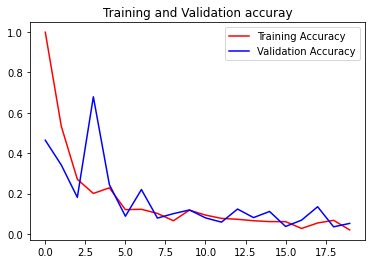

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label= 'Validation Accuracy')
plt.title('Training and Validation accuray')
plt.legend(loc=0)
plt.figure()
#show the graph
plt.show()

### xception

In [14]:
inp = Input(shape = (128, 128, 3))
x = inp
x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)

x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

x1 = Activation("relu")(x)
x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

"""x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])


x = Activation("relu")(x)
x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
"""
x = GlobalAveragePooling2D()(x)

x = Dense(6, activation = "softmax")(x)


model_2 = Model(inp, x)
#xception.summary()

In [23]:
epochs = 20

model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model_2.fit(x_train, y_train_one_hot, epochs=epochs,validation_data=(x_test,y_test_one_hot))

Epoch 1/20
118/118 [==============================] - 14s 106ms/step - loss: 0.6862 - accuracy: 0.7705 - val_loss: 1.7471 - val_accuracy: 0.2128
Epoch 2/20
118/118 [==============================] - 12s 101ms/step - loss: 0.4786 - accuracy: 0.8319 - val_loss: 1.6481 - val_accuracy: 0.3169
Epoch 3/20
118/118 [==============================] - 12s 101ms/step - loss: 0.3990 - accuracy: 0.8626 - val_loss: 1.4701 - val_accuracy: 0.3419
Epoch 4/20
118/118 [==============================] - 12s 101ms/step - loss: 0.3679 - accuracy: 0.8757 - val_loss: 0.9005 - val_accuracy: 0.6972
Epoch 5/20
118/118 [==============================] - 12s 100ms/step - loss: 0.3410 - accuracy: 0.8930 - val_loss: 0.7146 - val_accuracy: 0.7128
Epoch 6/20
118/118 [==============================] - 12s 100ms/step - loss: 0.3072 - accuracy: 0.9002 - val_loss: 0.9414 - val_accuracy: 0.6721
Epoch 7/20
118/118 [==============================] - 12s 100ms/step - loss: 0.2889 - accuracy: 0.9096 - val_loss: 0.4866 - val_ac

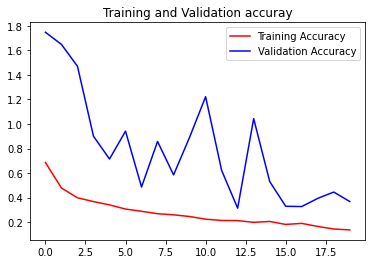

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label= 'Validation Accuracy')
plt.title('Training and Validation accuray')
plt.legend(loc=0)
plt.figure()
#show the graph
plt.show()

In [15]:
out1 = model_1.get_layer(index = -3).output
#out1 = GlobalAveragePooling2D()(out1)
out2 = model_2.get_layer(index= -2).output
#out2 = GlobalAveragePooling2D()(out2)
out = concatenate([out1,out2])
#out = Dense(512,activation='relu')(out)
#out = Dropout(0.25)(out)
#out = Dense(1024,activation='relu')(out)
#out = Dropout(0.50)(out)
out = Dense(6,activation='softmax')(out)

In [16]:
e_model = Model(inputs = [model_1.input,model_2.input],outputs = out)

### using k fold cross validation with k = 3

In [17]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
#kf = KFold(n_splits=3)

In [18]:
score = []
i = 0
epochs = 20
e_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

for trainset,testset in skfolds.split(x_train,y_train):

    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()

    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=x_train[trainset],x_train[testset]
    y_tr,y_te=to_categorical(y_train[trainset]),to_categorical(y_train[testset])

    #clone_clf = clone(svm)
    history = e_model.fit([x_train,x_train], y_train_one_hot, epochs=epochs,validation_data=([x_test,x_test],y_test_one_hot))
    predicted_labels = e_model.predict([x_te,x_te])
    accuracy = accuracy_score(y_te, predicted_labels)
    
    predicted_t_labels = e_model.predict([x_tr,x_tr])
    accuracy_t = accuracy_score(y_tr, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_te)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_tr)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[   1    2    5 ... 3744 3745 3746] having : 2498
[   0    3    4 ... 3739 3742 3747] having : 1250
Epoch 1/20
118/118 [==============================] - 39s 219ms/step - loss: 0.8125 - accuracy: 0.7092 - val_loss: 1.0231 - val_accuracy: 0.5102
Epoch 2/20
118/118 [==============================] - 22s 186ms/step - loss: 0.4408 - accuracy: 0.8327 - val_loss: 0.8801 - val_accuracy: 0.6127
Epoch 3/20
118/118 [==============================] - 22s 184ms/step - loss: 0.3600 - accuracy: 0.8698 - val_loss: 0.6317 - val_accuracy: 0.7981
Epoch 4/20
118/118 [==============================] - 22s 184ms/step - loss: 0.3164 - accuracy: 0.8879 - val_loss: 0.6389 - val_accuracy: 0.6839
Epoch 5/20
118/118 [==============================] - 22s 184ms/step - loss: 0.2479 - accuracy: 0.9138 - val_loss: 0.5488 - val_accuracy: 0.7833
Epoch 6/20
118/118 [==============================] - 22s 184ms/step - loss: 0.2218 - accuracy: 0.9210 - val_loss: 0.2783 - val_accuracy: 0.9006
Epoch 7/20
118/118 [=

ValueError: ignored

In [17]:
epochs = 20

e_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = e_model.fit([x_train,x_train], y_train_one_hot, epochs=epochs,validation_data=([x_test,x_test],y_test_one_hot))

Epoch 1/20
118/118 [==============================] - 33s 212ms/step - loss: 0.7985 - accuracy: 0.7137 - val_loss: 0.9751 - val_accuracy: 0.5164
Epoch 2/20
118/118 [==============================] - 22s 184ms/step - loss: 0.4090 - accuracy: 0.8487 - val_loss: 0.8455 - val_accuracy: 0.4797
Epoch 3/20
118/118 [==============================] - 22s 185ms/step - loss: 0.3428 - accuracy: 0.8794 - val_loss: 0.5790 - val_accuracy: 0.6901
Epoch 4/20
118/118 [==============================] - 22s 182ms/step - loss: 0.2702 - accuracy: 0.9061 - val_loss: 0.4215 - val_accuracy: 0.8576
Epoch 5/20
118/118 [==============================] - 22s 182ms/step - loss: 0.2269 - accuracy: 0.9234 - val_loss: 0.3201 - val_accuracy: 0.8740
Epoch 6/20
118/118 [==============================] - 22s 183ms/step - loss: 0.1944 - accuracy: 0.9341 - val_loss: 0.3351 - val_accuracy: 0.8670
Epoch 7/20
118/118 [==============================] - 22s 184ms/step - loss: 0.1525 - accuracy: 0.9482 - val_loss: 0.2209 - val_ac

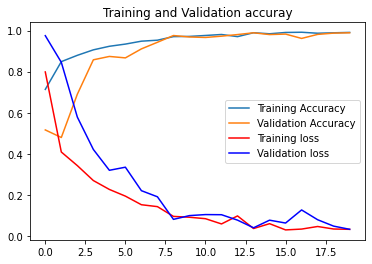

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label= 'Validation Accuracy')
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and Validation accuray')
plt.legend(loc=0)
plt.figure()
#show the graph
plt.show()

### confusion matrix

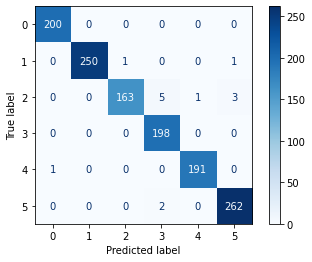

In [22]:
y_test_n = np.argmax(y_test_one_hot,axis = 1)
y_pred = e_model.predict([x_test,x_test])
y_pred = np.argmax(y_pred,axis = -1)
cm = confusion_matrix(y_test_n, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
print("Feature extraction ...")
prediction = np.array(e_model.predict([x_train,x_train]))
prediction.shape

Feature extraction ...


(3748, 1152)

In [ ]:
Xtrain = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

In [ ]:
prediction = np.array(e_model.predict([x_test,x_test]))

In [ ]:
Xtest = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

In [ ]:
print("Classification with Linear SVM ...")
svm = SVC(kernel='linear',probability=True)
svm.fit(Xtrain, np.ravel(y_train, order='C'))
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_test, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)

Classification with Linear SVM ...
	Accuracy Linear SVM: 0.9069


In [ ]:
#skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
skfolds = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
kf = KFold(n_splits=3)

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
#kernels = ["linear", "poly", "rbf"]
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid,cv=skfolds,)
grid.fit(Xtrain, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [ ]:
print(grid.best_score_,grid.best_params_)

0.9435555555555556 {'C': 10000.0, 'gamma': 0.001}


In [ ]:
df = pd.DataFrame(grid.cv_results_)
mask = df['rank_test_score']<5
newdf = df[mask]
newdf[['param_C','param_gamma','mean_test_score','std_test_score','rank_test_score']]

,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
84,10000.0,0.001,0.943556,0.004532,1
98,100000.0,0.01,0.942667,0.007542,3
108,1000000.0,0.00001,0.943111,0.002266,2
111,1000000.0,0.01,0.942667,0.007542,3
124,10000000.0,0.01,0.942667,0.007542,3
137,100000000.0,0.01,0.942667,0.007542,3
150,1000000000.0,0.01,0.942667,0.007542,3
163,10000000000.0,0.01,0.942667,0.007542,3


In [ ]:
svm = SVC(kernel='rbf',C=1000,gamma=0.1)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_train):

    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()

    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_tr,y_te=y_train[trainset],y_train[testset]

    #clone_clf = clone(svm)
    svm.fit(x_tr, y_tr)
    predicted_labels = svm.predict(x_te)
    accuracy = accuracy_score(y_te, predicted_labels)
    
    predicted_t_labels = svm.predict(x_tr)
    accuracy_t = accuracy_score(y_tr, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_te)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_tr)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[3646 1667 3293 ... 2258  357 2165] having : 2998
[  75   34 1566  640 1290 2014  331 1051  306 3710 2548 1618 2467   48
 3081 1623 2493 2809  117 2345 1563 1546 2707 2745 1351 3394   18 1833
 2310 2316 3035 2134 2608 1150 1426 3653 2779  851 1090 2974 1767 1346
 2828 2052 2863  869 3060  627 1916 2015  102 2376 3601 3521 3410 2740
 1390 2296  931 2184 1852 3164 3075  940  258 2858  718   38 1619 2423
  558 3614 1256  397 1644  772 3604  591  531 2880  648  683 3042  587
  362 1699 1610 1212 2524 3522  966 1415  423 1560 2889 2728  784 2086
 3108   40 3641 3544 1622 2629 3435 2759 2830  201  460  682 3470  323
  818 3017 3019 1231 2739  749 1098 2513 2835 1253 2131 2176 3343 2706
 1684  876 3373 2366 2263  342 2391 1542 1879 2120 1338  284 1386  377
   50 3204  405 2324 3048 1376 1947  566 2418 1108 3223 2488  104  845
 3264 3033  911 2883 2106  626 1238 3348 1070 1673  440  965 1393 1821
  209 2141   92  200 2511 2530 1692 2287  108 2622 2667 2114 2815  890
 3560  732 1922 31

	Validation Accuracy of SVM: 0.9373


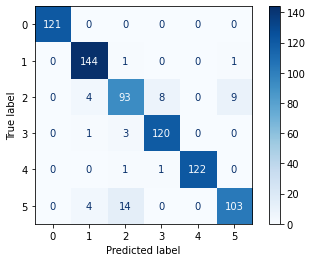

	Training Accuracy of SVM: 1.0000


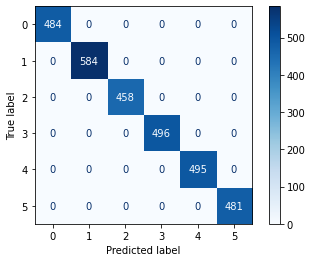

In [ ]:
    acc = accuracy_score(predicted_labels, np.ravel(y_te, order='C'))
    print("\tValidation Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
    disp.plot(cmap='Blues')
    plt.show()
    
    acc = accuracy_score(predicted_t_labels, np.ravel(y_tr, order='C'))
    print("\tTraining Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
    disp.plot(cmap='Blues')
    plt.show()

	 Testing Accuracy of SVM: 0.9069


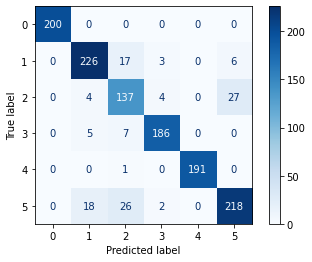

**************classification report for Tesing************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.86      0.93      0.90       252
           2       0.76      0.78      0.77       172
           3       0.96      0.93      0.95       198
           4       1.00      0.99      1.00       192
           5       0.87      0.81      0.84       264

    accuracy                           0.91      1278
   macro avg       0.91      0.91      0.91      1278
weighted avg       0.91      0.91      0.91      1278



In [ ]:
result_test = svm.predict(Xtest)
acc_test = accuracy_score(result, np.ravel(y_test, order='C'))

print("\t Testing Accuracy of SVM: %0.4f" % acc_test)

cm = confusion_matrix(y_test, result_test, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
disp.plot(cmap='Blues')
plt.show()
print("**************classification report for Tesing************")
print(classification_report(y_test,result))

In [ ]:
svm = SVC(kernel='rbf',C=100,gamma=0.1)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_train):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_tr,y_te=y_train[trainset],y_train[testset]

    #clone_clf = clone(svm)
    svm.fit(x_tr, y_tr)
    predicted_labels = svm.predict(x_te)
    accuracy = accuracy_score(y_te, predicted_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_te)
    accuracy_list.append(accuracy)
    
    #label = {0:'cbd',1: 'rust', 2: 'phoma', 3: 'mold', 4: 'miner',5 : 'healthy'}
    #cm = ConfusionMatrix(svm, classes=svm.classes_,label_encoder=label)

    #cm.fit(x_tr, y_tr)
    #cm.score(x_te, y_te)
    #cm.show()
    print("iteration", i)
    i+=1

folds  0
[   1    2    5 ... 3744 3745 3747] having : 2498
[   0    3    4 ... 3742 3743 3746] having : 1250
iteration 0
folds  1
[   0    1    2 ... 3744 3745 3746] having : 2499
[   5    9   14 ... 3740 3741 3747] having : 1249
iteration 1
folds  2
[   0    3    4 ... 3743 3746 3747] having : 2499
[   1    2    7 ... 3739 3744 3745] having : 1249
iteration 2


In [ ]:
cm = confusion_matrix(actual_targets, predicted_targets, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
result = svm.predict(Xtrain)

acc = accuracy_score(result, np.ravel(y_train, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)

In [ ]:
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_test, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)
print(classification_report(y_test,result))

In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix
from scikitplot.metrics import plot_confusion_matrix,plot_roc

In [ ]:
label = {0:'cbd',1: 'healthy', 2: 'miner', 3: 'mold', 4: 'phoma',5 : 'rust'}
cm = ConfusionMatrix(svm,label_encoder='label',cmap='Blues',encoder=label)
cm.fit(Xtrain, y_train)
cm.score(Xtrain, y_train)
cm.show()

In [ ]:
label = {0:'cbd',1: 'healthy', 2: 'miner', 3: 'mold', 4: 'phoma',5 : 'rust'}
cm = ConfusionMatrix(svm,label_encoder=label,percent=True,cmap='Blues',encoder=label)
cm.fit(Xtrain, y_train)
cm.score(Xtest, y_test)
cm.show()

In [ ]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'healthy', 2: 'miner', 3: 'mold', 4: 'phoma',5 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [ ]:
plot_ROC_curve(svm,Xtrain,y_train,Xtest,y_test)

In [ ]:
rf = RandomForestClassifier(n_estimators=50,random_state=42)
rf.fit(Xtrain, np.ravel(y_train, order='C'))
result_rf = rf.predict(Xtest)
acc = accuracy_score(result_rf, np.ravel(y_test, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)
print(classification_report(y_test,result))

In [ ]:
inp = Input(shape = (32, 32, 3))
x = inp
x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)

x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

x1 = Activation("relu")(x)
x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])


x = Activation("relu")(x)
x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

x = Dense(100, activation = "softmax")(x)


xception = Model(inp, x)
xception.summary()